In [1]:
using OpenCL
using PyPlot

## OpenCL GPU Mandelbrot Fractal Implementation

In [19]:
# This will probably be different on your computer
cl.devices()

3-element Array{OpenCL.cl.Device,1}:
 OpenCL.Device(Intel(R) Core(TM) i7-3720QM CPU @ 2.60GHz on Apple @0x00000000ffffffff)
 OpenCL.Device(HD Graphics 4000 on Apple @0x0000000001024400)                         
 OpenCL.Device(GeForce GT 650M on Apple @0x0000000001022700)                          

In [2]:
mandel_source = "
__kernel void mandelbrot(__global float2 *q,
                         __global ushort *output, 
                         ushort const maxiter)
{
 int gid = get_global_id(0);
 float nreal, real = 0;
 float imag = 0;
 output[gid] = 0;
 for(int curiter = 0; curiter < maxiter; curiter++) {
     nreal = real*real - imag*imag + q[gid].x;
     imag = 2* real*imag + q[gid].y;
     real = nreal;

     if (real*real + imag*imag > 4.0f)
         output[gid] = curiter;
  }
}";

In [3]:
function mandel_opencl(q::Array{Complex64}, maxiter::Int64, device)
    ctx   = cl.Context(device)
    queue = cl.CmdQueue(ctx)

    out = Array{UInt16}(undef, size(q))

    q_buff = cl.Buffer(Complex64, ctx, (:r, :copy), hostbuf=q)
    o_buff = cl.Buffer(UInt16, ctx, :w, length(out))

    prg = cl.Program(ctx, source=mandel_source) |> cl.build!
    
    k = cl.Kernel(prg, "mandelbrot")
    #cl.call(queue, k, length(out), nothing, q_buff, o_buff, uint16(maxiter))
    queue(k, length(q), nothing, q_buff, o_buff, UInt16(maxiter))


    cl.copy!(queue, out, o_buff)
    
    return out
end

mandel_opencl (generic function with 1 method)

In [4]:
w = 2048 * 2;
h = 2048 * 2;
@printf("Size %i MB\n", sizeof(Complex64) * w * h / 1024 / 1024)

q = [Complex64(r,i) for i=1:-(2.0/w):-1, r=-1.5:(3.0/h):1.5];

Size 128 MB


In [5]:
function build_q(w, h)
    y1 = -1.0
    y2 = 1.0
    x1 = -1.5
    x2 = 0.5
    
    q = Array{Complex64}(undef, h, w)
    for x in 1:w
        for y in 1:h
            xx = x1 + x * ((x2 - x1) / w)
            yy = y1 + y * ((y2 - y1) / h)
            @inbounds q[y, x] = Complex64(xx, yy)
        end
    end

    return q
end

q = build_q(w, h);

#### Device 1: Intel i7-3720QM CPU @ 2.60GHz

In [6]:
device = cl.devices()[1]

OpenCL.Device(Intel(R) Core(TM) i7-3720QM CPU @ 2.60GHz on Apple @0x00000000ffffffff)

In [7]:
@time m = mandel_opencl(q, 200, device);

  3.276737 seconds (413.24 k allocations: 54.710 MiB, 2.77% gc time)


In [8]:
@time m = mandel_opencl(q, 200, device);

  1.953214 seconds (159 allocations: 32.006 MiB, 0.88% gc time)


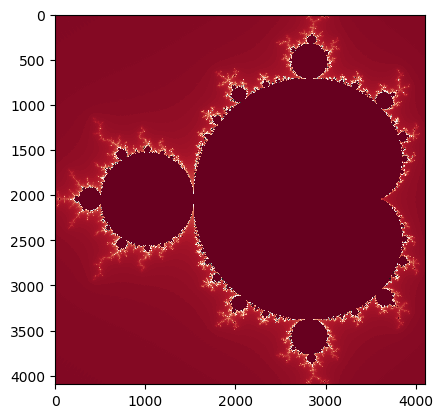

PyObject <matplotlib.image.AxesImage object at 0x13b970cd0>

In [9]:
imshow(m, cmap="RdGy")

#### Device 2: Intel HD Graphics 4000

In [10]:
device = cl.devices()[2]

OpenCL.Device(HD Graphics 4000 on Apple @0x0000000001024400)

In [11]:
@time m = mandel_opencl(q, 200, device);

  1.032201 seconds (163 allocations: 32.006 MiB, 0.83% gc time)


In [12]:
@time m = mandel_opencl(q, 200, device);

  0.755561 seconds (169 allocations: 32.007 MiB, 1.02% gc time)


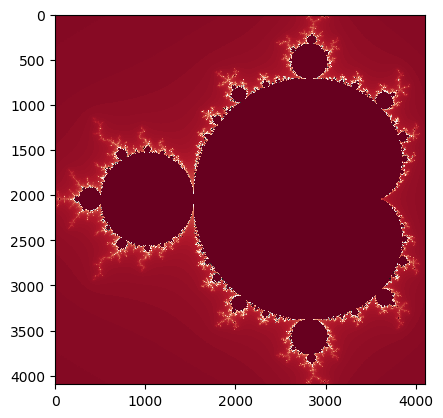

PyObject <matplotlib.image.AxesImage object at 0x136d570d0>

In [13]:
imshow(m, cmap="RdGy")

#### Device 3: Geforce 650M

In [14]:
device = cl.devices()[3]

OpenCL.Device(GeForce GT 650M on Apple @0x0000000001022700)

In [15]:
@time m = mandel_opencl(q, 200, device);

  0.997026 seconds (174 allocations: 32.007 MiB, 0.67% gc time)


In [16]:
@time m = mandel_opencl(q, 200, device);

  0.447465 seconds (169 allocations: 32.007 MiB, 1.05% gc time)


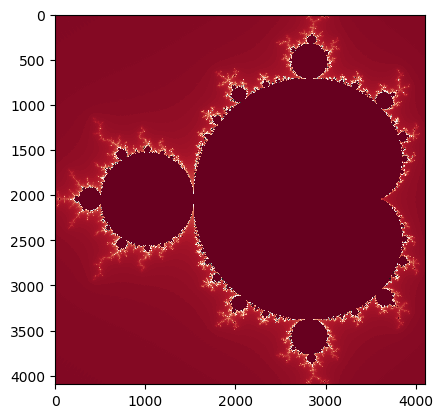

PyObject <matplotlib.image.AxesImage object at 0x136dc8cd0>

In [17]:
imshow(m, cmap="RdGy")